# **PLAY WITH CHESS_BOT**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chess-bot-model/chess_model.keras


In [2]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 49.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=b8ac6f873c5b4a6928cb91c692cd43489dac521d161e7228242d5badc256d2b8
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


In [3]:
import chess
import chess.svg
import chess.pgn
import io
from IPython.display import SVG, display

**Helper Functions**

In [4]:
# Numeric representation of each piece 'a'- for white pieces and 'A'- for black pieces

''' In this I went a bit out of convention. This is the correct convention 'A'- for white 
    and 'a'- for black.
    In later part the correct convention is followed and in code 'piece_weight' are multiplied 
    with a extra '-1' to rectify the error.
'''

num_piece = {'p':0,'n':1,'b':2,'r':3,'q':4,'k':5,
             'P':6,'N':7,'B':8,'R':9,'Q':10,'K':11}

piece_weight = {'p':1,'n':3,'b':3,'r':5,'q':9,'k':0,
             'P':-1,'N':-3,'B':-3,'R':-5,'Q':-9,'K':0}

In [5]:
# extracting each move as FEN from PGN

def pgn_to_fen(PGN):
  fen = []
  pgn = io.StringIO(PGN)
  game = chess.pgn.read_game(pgn)
  for move in game.mainline_moves():
    fen.append(b.fen())
  return fen

In [6]:
# converting a FEN to a 12x8x8 matrix: 8x8 for board and x12 for each type of chess piece

def fen_to_matrix(FEN):
  matrix = np.zeros((12,8,8))
  b = chess.Board(FEN)
  for square,piece in b.piece_map().items():
    r = 7 - square//8
    c = square%8
    matrix[num_piece[str(piece)],r,c] = 1
  return matrix

In [7]:
# Calculating material points

def material_points(FEN):
  white_point = 0
  black_point = 0

  b = chess.Board(FEN)
  for square,piece in b.piece_map().items():
    if str(piece).isupper():
      white_point = white_point + piece_weight[str(piece)]
    elif str(piece).islower():
      black_point = black_point + piece_weight[str(piece)]
  return white_point,black_point

In [8]:
#  additional features to the board matrix

def add_board(matrix,turn,FEN):

  # side to move
  side_plane = np.ones((1,8,8)) * turn

  # castling rights
  castle = []
  if(board.has_kingside_castling_rights(chess.WHITE)):
    castling_plane = castle.append(np.ones((8,8)))
    castling_plane = castle.append(np.zeros((8,8)))
  else:
    castling_plane = castle.append(np.zeros((8,8)))
    castling_plane = castle.append(np.ones((8,8)))
  if(board.has_kingside_castling_rights(chess.BLACK)):
    castling_plane = castle.append(np.ones((8,8)))
    castling_plane = castle.append(np.zeros((8,8)))
  else:
    castling_plane = castle.append(np.zeros((8,8)))
    castling_plane = castle.append(np.ones((8,8)))
      
  # material points
  white_point,black_point = material_points(FEN)
  material_advantage = black_point + white_point
  material = np.full((1, 8, 8),material_advantage,dtype=np.float32) * (-1*turn)

  add_matrix = np.concatenate([matrix, side_plane, castle, material], axis=0)

  return add_matrix


In [9]:
# Gives index(out of 4672) for the move played in a position

def move_played_idx(move):

  # indexing move
  from_sq = move.from_square
  to_sq = move.to_square
  from_rank = chess.square_rank(from_sq)
  from_file = chess.square_file(from_sq)
  to_rank = chess.square_rank(to_sq)
  to_file = chess.square_file(to_sq)

  d_file = to_file - from_file
  d_rank = to_rank - from_rank

  # sliding moves
  slide_dir = [(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1),(-1,0),(-1,1)]

  for dir_idx,(dx,dy) in enumerate(slide_dir):
    for dist in range(1,8):
      if d_file == dx*dist and d_rank == dy*dist:
        move_type = dir_idx*7 + dist - 1
        return from_sq*73 + move_type
          
  # knight move
  knight_dir = [(1,2),(2,1),(2,-1),(1,-2),(-1,-2),(-2,-1),(-2,1),(-1,2)]
  for dir_idx,(dx,dy) in enumerate(knight_dir):
    if d_file == dx and d_rank == dy:
      move_type = 56 + dir_idx
      return from_sq*73 + move_type

  # underpromotion
  if move.promotion is not None:
    promo_map = {chess.KNIGHT:0,chess.BISHOP:1,chess.ROOK:2}
    if move.promotion in promo_map:
      is_capture = (d_file != 0)
      move_type = 64 + (is_capture*3) + promo_map[move.promotion]
      return from_sq*73 + move_type

  return None

In [10]:
# Loading model

import tensorflow as tf

model = tf.keras.models.load_model("/kaggle/input/chess-bot-model/chess_model.keras")

2025-12-29 18:16:39.047969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767032199.277204      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767032199.344320      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767032199.906319      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767032199.906376      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767032199.906379      55 computation_placer.cc:177] computation placer alr

## **MOVE GENERATION**

In [11]:
# Chosen policy index to final playable move

def policy_index_to_move(chosen_idx, board):

    from_sq = chosen_idx // 73
    move_type = chosen_idx % 73

    from_file = chess.square_file(from_sq)
    from_rank = chess.square_rank(from_sq)

    piece = board.piece_at(from_sq)

    if piece is None:
        return None

    # Sliding moves

    if move_type < 56:
        dir_idx = move_type // 7
        dist = (move_type % 7) + 1

        slide_dir = [(0,1),(1,1),(1,0),(1,-1),
                     (0,-1),(-1,-1),(-1,0),(-1,1)]

        dx, dy = slide_dir[dir_idx]
        to_file = from_file + dx * dist
        to_rank = from_rank + dy * dist

        if 0 <= to_file < 8 and 0 <= to_rank < 8:
            to_sq = chess.square(to_file, to_rank)

            # Queen promotion
            if piece.piece_type == chess.PAWN and to_rank in (0, 7):
                move = chess.Move(from_sq, to_sq, promotion=chess.QUEEN)
            else:
                move = chess.Move(from_sq, to_sq)

            if move in board.legal_moves:
                return move

    # Knight moves

    elif move_type < 64:
        knight_dir = [(1,2),(2,1),(2,-1),(1,-2),
                      (-1,-2),(-2,-1),(-2,1),(-1,2)]

        dx, dy = knight_dir[move_type - 56]
        to_file = from_file + dx
        to_rank = from_rank + dy

        if 0 <= to_file < 8 and 0 <= to_rank < 8:
            to_sq = chess.square(to_file, to_rank)
            move = chess.Move(from_sq, to_sq)

            if move in board.legal_moves:
                return move

    # Underpromotions

    elif move_type < 70:
        promo_idx = move_type - 64
        is_capture = promo_idx // 3
        piece_idx = promo_idx % 3

        promo_map = [chess.KNIGHT, chess.BISHOP, chess.ROOK]
        promotion = promo_map[piece_idx]

        direction = 1 if board.turn == chess.WHITE else -1
        to_rank = from_rank + direction
        to_file = from_file + (-1 if is_capture else 1 if is_capture else 0)

        if 0 <= to_file < 8 and 0 <= to_rank < 8:
            to_sq = chess.square(to_file, to_rank)
            move = chess.Move(from_sq, to_sq, promotion=promotion)

            if move in board.legal_moves:
                return move

    return None

In [12]:
# Chess board to CNN input

def board_to_model_input(board):
    fen = board.fen()
    mat12 = fen_to_matrix(fen)
    turn = 1 if board.turn == chess.WHITE else -1
    X = add_board(mat12, turn, fen)
    return X

In [13]:
# Masking illegal moves

def get_legal_policy(policy, board):
    legal_moves = list(board.legal_moves)

    legal_policy = np.zeros_like(policy)

    for move in legal_moves:
        uci = move.uci()
        idx = move_played_idx(move)
        if idx is not None:
            legal_policy[idx] = policy[idx]

    if legal_policy.sum() == 0:
        for move in legal_moves:
            idx = move_played_idx[move.uci()]
            legal_policy[idx] = 1.0

    return legal_policy

In [14]:
# Move Selection

def select_move_from_policy(policy, board, temperature=0.8):
    legal_policy = get_legal_policy(policy, board)

    probs = np.power(legal_policy, 1 / temperature)
    probs = probs / np.sum(probs)

    chosen_idx = np.random.choice(len(probs), p=probs)

    return policy_index_to_move(chosen_idx,board)

In [15]:
# Engine move played

def engine_move(board, model, temperature=0.8):
    X = board_to_model_input(board)
    X = np.expand_dims(X, axis=0)

    policy, value = model.predict(X, verbose=0)

    policy = policy[0]
    value = value[0][0]

    move = select_move_from_policy(policy, board, temperature)

    if move is None or move not in board.legal_moves:
        move = np.random.choice(list(board.legal_moves))

    board.push(move)
    return move, value

# **FINAL GAME**

## **HOW TO PLAY :** 
1. Run all the above cells in order
2. Run the below cell to start the game
3. Enter the side you want to play as: w - White or b - Black
4. Enter your moves in the format: "start_square__end_square". ex. "e2e4"
5. To stop the game interrupt the cell by clicking the 'run cell' button
6. To start a new game re-run the cell

Do you want to play as white or black? (w/b):  b


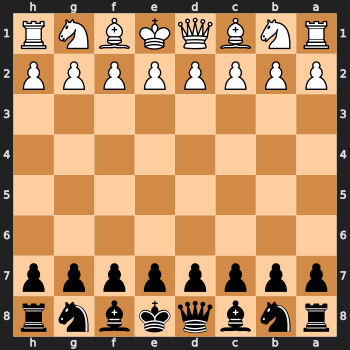




Engine thinking...


I0000 00:00:1767032256.306369     126 service.cc:152] XLA service 0x7e0ca4011cc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767032256.306435     126 service.cc:160]   StreamExecutor device (0): Host, Default Version


Engine plays: g2g4


I0000 00:00:1767032257.234242     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


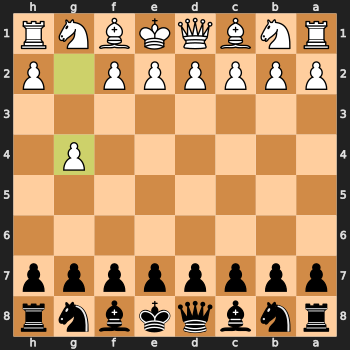

Your move (uci):  d7d5


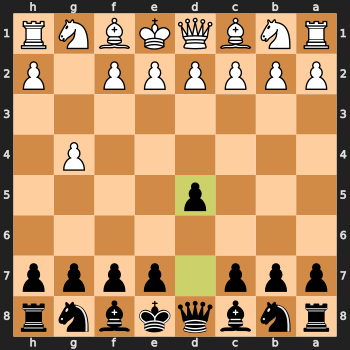




Engine thinking...
Engine plays: h2h4


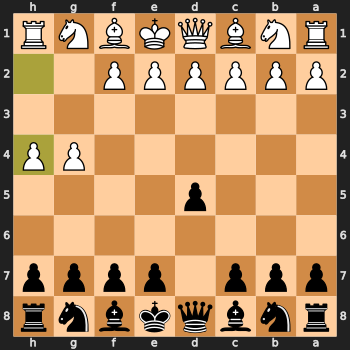

Your move (uci):  g8f6


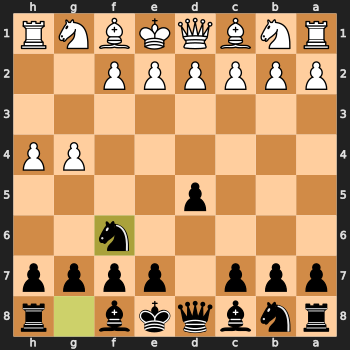




Engine thinking...
Engine plays: b1c3


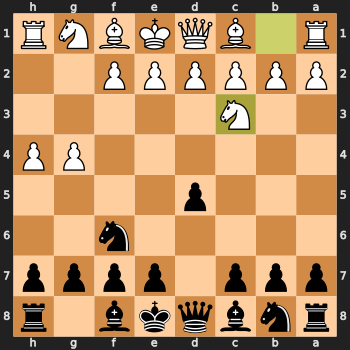

Your move (uci):  c8g4


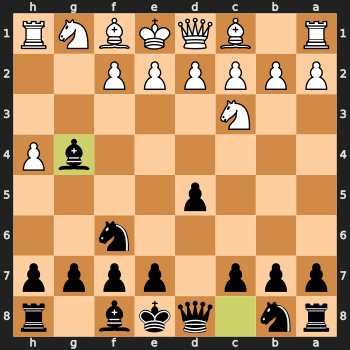




Engine thinking...
Engine plays: f2f4


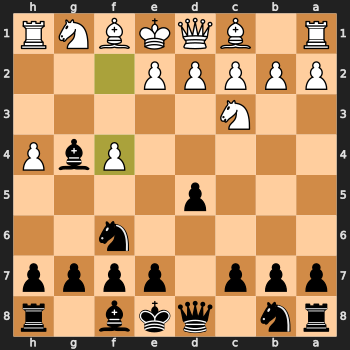

Your move (uci):  b8c6


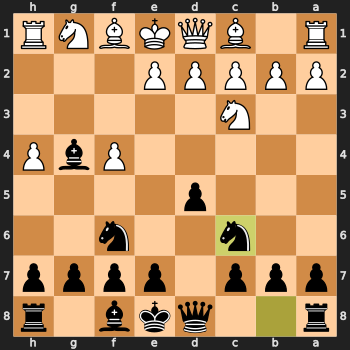




Engine thinking...
Engine plays: d2d4


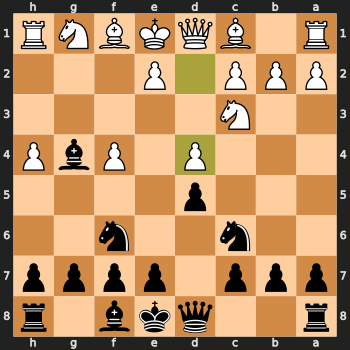

Your move (uci):  e7e6


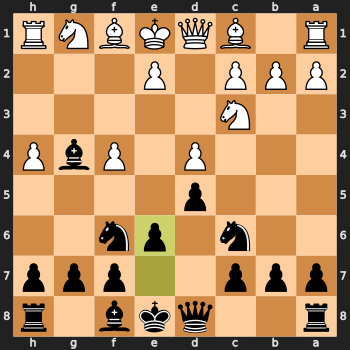




Engine thinking...
Engine plays: h1h3


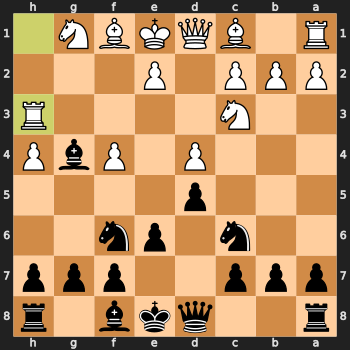

Your move (uci):  f8b4


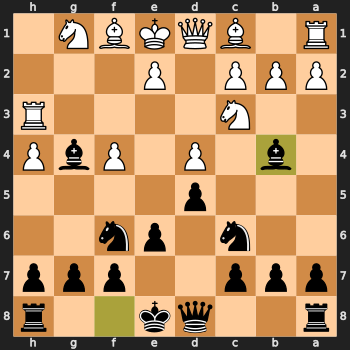




Engine thinking...
Engine plays: g1f3


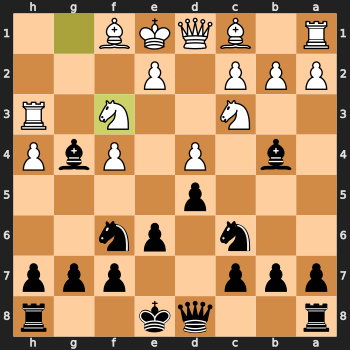

Your move (uci):  g4f3


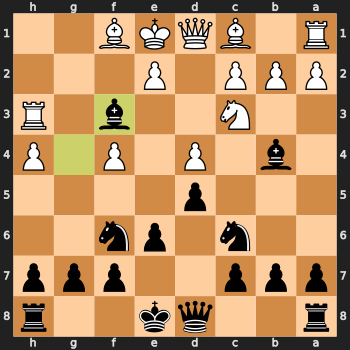




Engine thinking...
Engine plays: f1g2


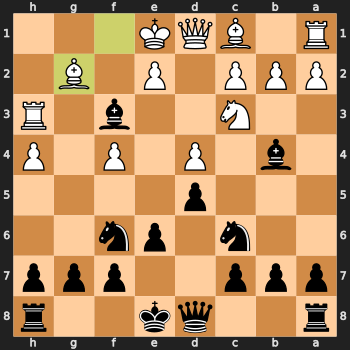

Your move (uci):  e8g8


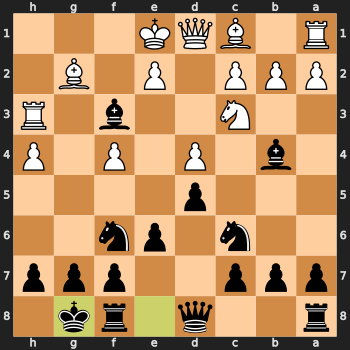




Engine thinking...
Engine plays: d1d3


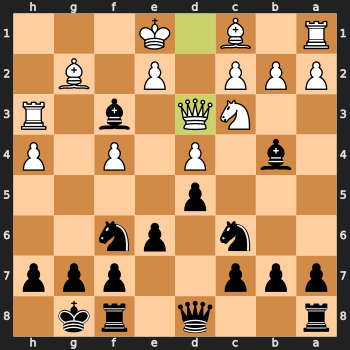

Your move (uci):  a7a5


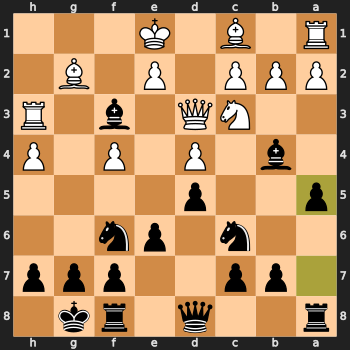




Engine thinking...
Engine plays: e2e3


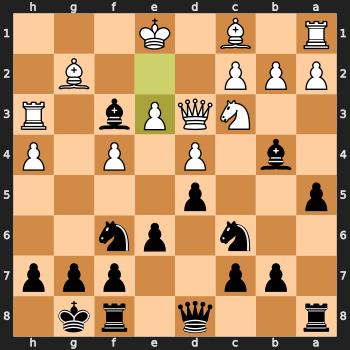

Your move (uci):  f6e4


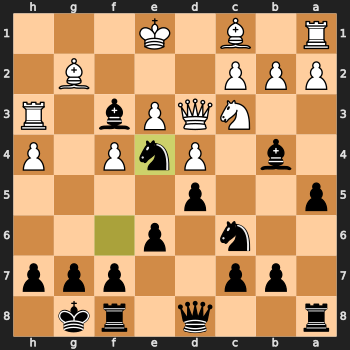




Engine thinking...
Engine plays: a2a3


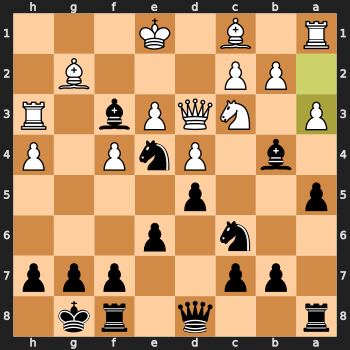

Your move (uci):  b7b6


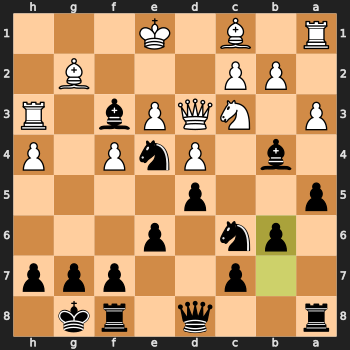




Engine thinking...
Engine plays: c1d2


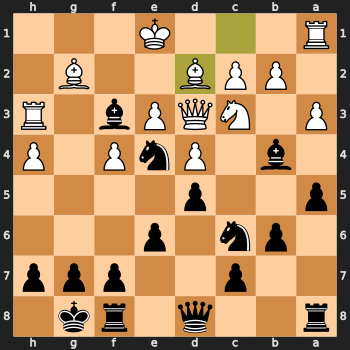

Your move (uci):  c6e5


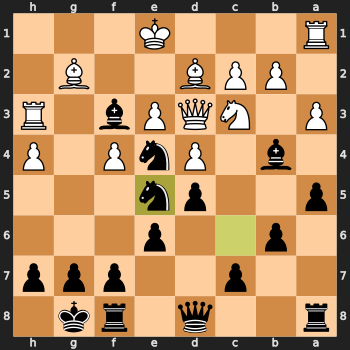




Engine thinking...
Engine plays: d4e5


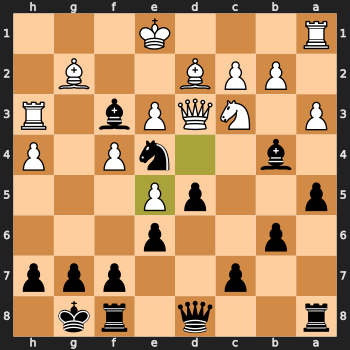

Your move (uci):  e4d2


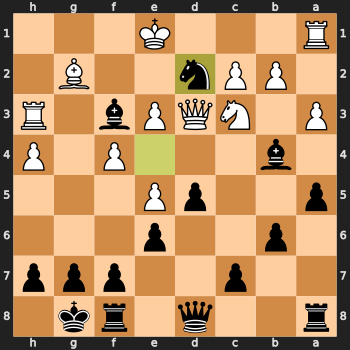




Engine thinking...
Engine plays: f4f5


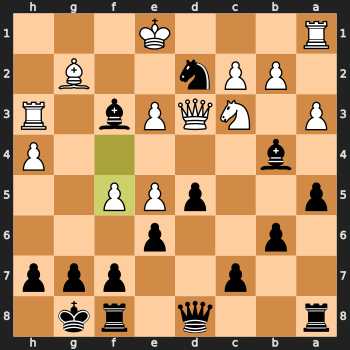

Your move (uci):  c7c5


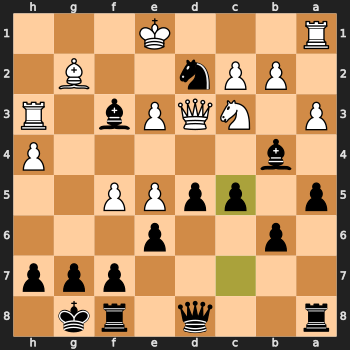




Engine thinking...
Engine plays: f5e6


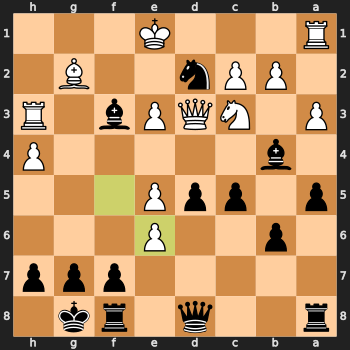

Your move (uci):  f8e8


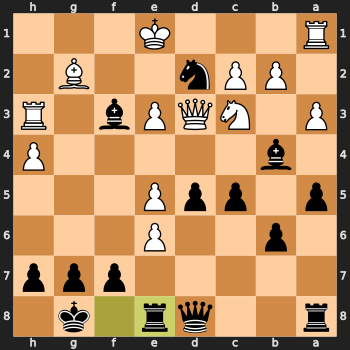




Engine thinking...
Engine plays: c3e4


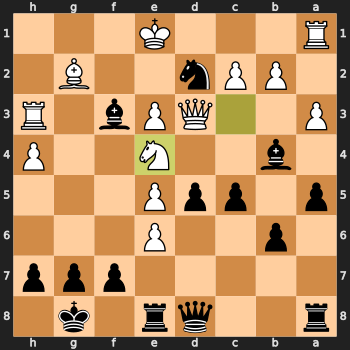

Your move (uci):  d5d4


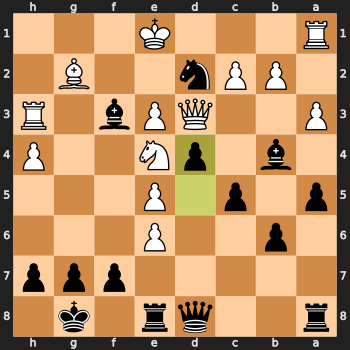




Engine thinking...
Engine plays: g2f1


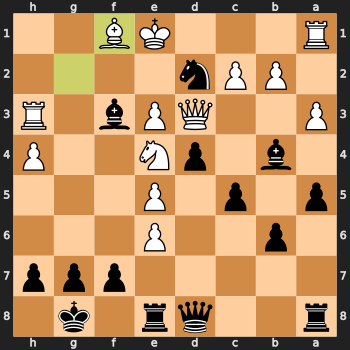

Your move (uci):  d8d5


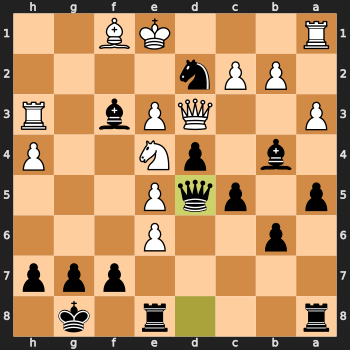




Engine thinking...
Engine plays: f1e2


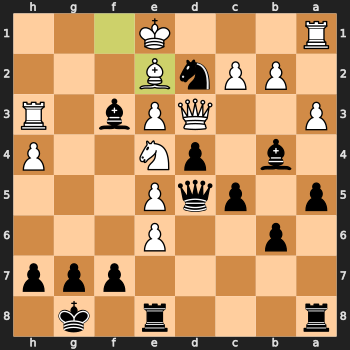

Your move (uci):  d2b1


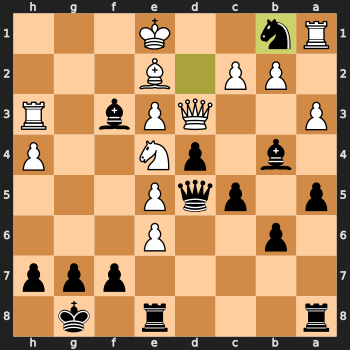




Engine thinking...
Engine plays: e1d1


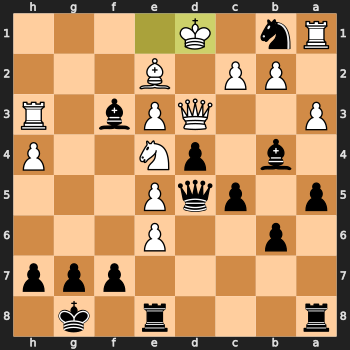

KeyboardInterrupt: Interrupted by user

In [16]:
while True:
    user_color = input("Do you want to play as white or black? (w/b): ").strip().lower()
    if user_color in ['w', 'b']:
        break
    print("Invalid input! Please enter 'w' for white or 'b' for black.")

user_is_white = user_color == 'w'
flip_board = not user_is_white

board = chess.Board()
move_ct = 0

while not board.is_game_over():

    move_ct += 1

    # Display SVG board with last move highlighted
    if board.move_stack:
        display(SVG(chess.svg.board(board, lastmove=board.peek(), size=350, flipped=flip_board)))
    else:
        display(SVG(chess.svg.board(board, size=350,flipped=flip_board)))
    print("\n\n")

    if board.turn == chess.WHITE:
        if user_is_white:
            move_uci = input("Your move (uci): ")
            move = chess.Move.from_uci(move_uci)
            if move not in board.legal_moves:
                print("Illegal move!")
                continue
            board.push(move)
        else:
            print("Engine thinking...")
            move, value = engine_move(board, model, temperature=0.7)
            print("Engine plays:", move)
    else:
        if not user_is_white:
            move_uci = input("Your move (uci): ")
            move = chess.Move.from_uci(move_uci)
            if move not in board.legal_moves:
                print("Illegal move!")
                continue
            board.push(move)
        else:
            print("Engine thinking...")
            move, value = engine_move(board, model, temperature=0.7)
            print("Engine plays:", move)

display(SVG(chess.svg.board(board, lastmove=board.peek(), size=350,flipped=flip_board)))
print("\n\n")
print("GAME OVER (White-Black):", board.result())
print("Move Count : ",move_ct)